Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None

Basic Statistics:
              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.

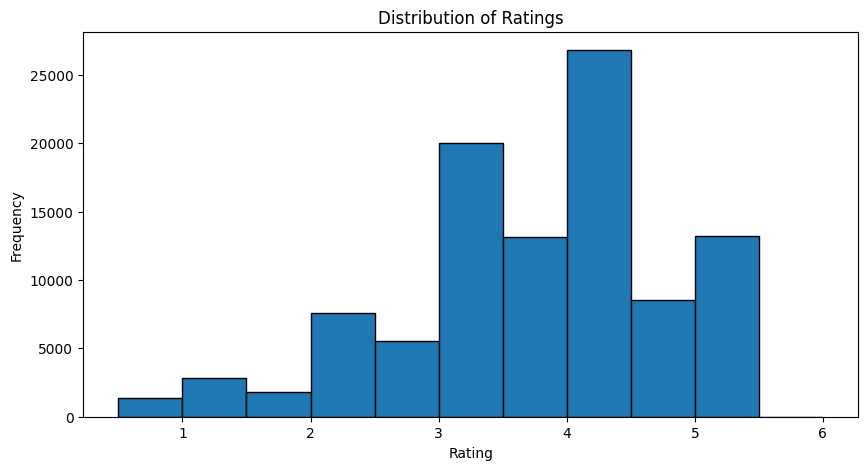

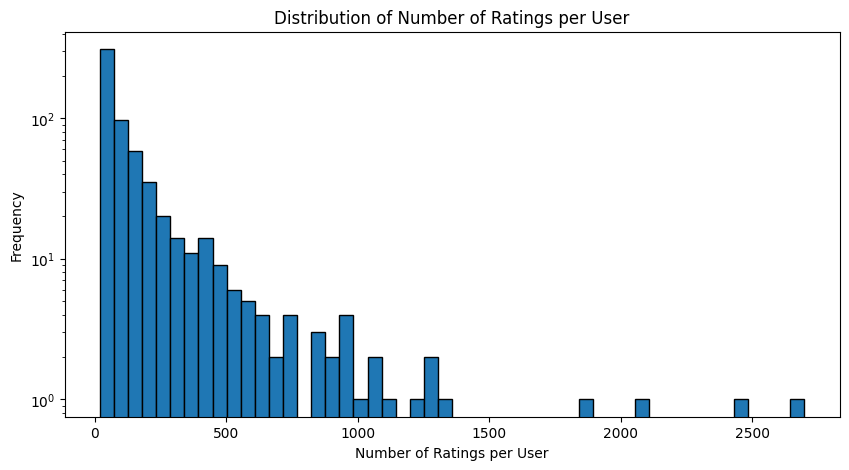

Percentage of Missing Ratings: 98.30%


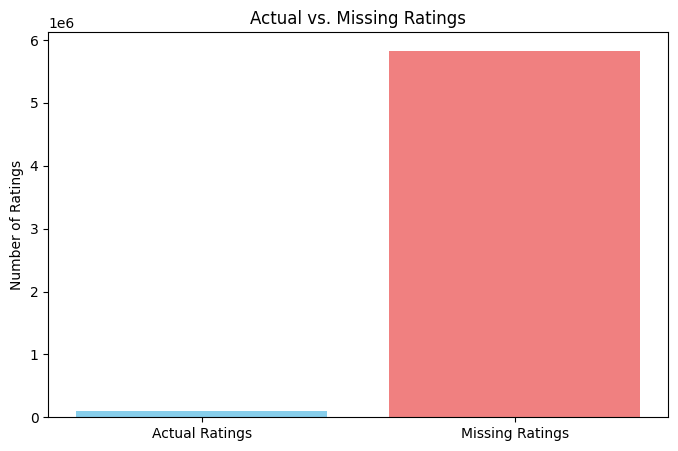

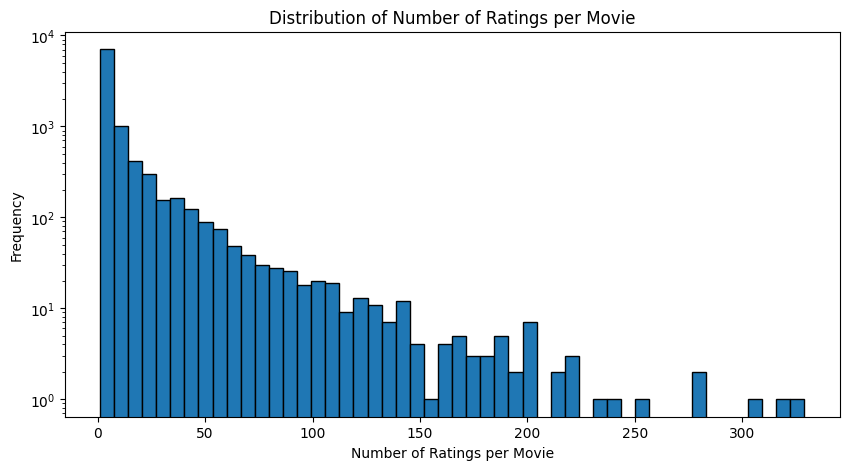

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from joblib import Parallel, delayed


ratings_df = pd.read_csv("ratings.csv")


print("Dataset Information:")
print(ratings_df.info())
print("\nBasic Statistics:")
print(ratings_df.describe())

plt.figure(figsize=(10, 5))
plt.hist(ratings_df['rating'], bins=np.arange(0.5, 6.5, 0.5), edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

ratings_per_user = ratings_df['userId'].value_counts()
plt.figure(figsize=(10, 5))
plt.hist(ratings_per_user, bins=50, edgecolor='black')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Ratings per User')
plt.yscale('log')
plt.show()
n_users = ratings_df['userId'].nunique()
n_items = ratings_df['movieId'].nunique()

n_possible_ratings = n_users * n_items
n_actual_ratings = len(ratings_df)
missing_percentage = 100 * (n_possible_ratings - n_actual_ratings) / n_possible_ratings
print(f"Percentage of Missing Ratings: {missing_percentage:.2f}%")

plt.figure(figsize=(8, 5))
plt.bar(['Actual Ratings', 'Missing Ratings'], [n_actual_ratings, n_possible_ratings - n_actual_ratings], color=['skyblue', 'lightcoral'])
plt.ylabel('Number of Ratings')
plt.title('Actual vs. Missing Ratings')
plt.show()

ratings_per_movie = ratings_df['movieId'].value_counts()
plt.figure(figsize=(10, 5))
plt.hist(ratings_per_movie, bins=50, edgecolor='black')
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Ratings per Movie')
plt.yscale('log')
plt.show()

In [2]:
user_id_mapping = {id: idx for idx, id in enumerate(ratings_df['userId'].unique())}
movie_id_mapping = {id: idx for idx, id in enumerate(ratings_df['movieId'].unique())}

# Initialize latent factor matrices
n_factors = 50  # Number of latent factors
P = np.random.normal(scale=1./n_factors, size=(n_users, n_factors))
Q = np.random.normal(scale=1./n_factors, size=(n_items, n_factors))

# Hyperparameters
learning_rate = 0.005
n_epochs = 50
reg = 0.2

# Hide some of the ratings for testing
ratings_df['train_test_split'] = np.random.rand(len(ratings_df))
train_data = ratings_df[ratings_df['train_test_split'] <= 0.8]
test_data = ratings_df[ratings_df['train_test_split'] > 0.8]

# Convert train_data to numpy array for faster access
train_data_np = train_data[['userId', 'movieId', 'rating']].values

# Training the Funk SVD model
train_losses = []
for epoch in range(n_epochs):
    np.random.shuffle(train_data_np)
    for i in range(len(train_data_np)):
        user_id = train_data_np[i, 0]
        movie_id = train_data_np[i, 1]
        rating = train_data_np[i, 2]

        user_idx = user_id_mapping[user_id]
        movie_idx = movie_id_mapping[movie_id]

        # Predict the rating
        prediction = max(0, np.dot(P[user_idx], Q[movie_idx]))
        error = rating - prediction

        # Update user and item latent factors
        P[user_idx] += learning_rate * (error * Q[movie_idx] - reg * P[user_idx])
        Q[movie_idx] += learning_rate * (error * P[user_idx] - reg * Q[movie_idx])

        # Clip values to prevent overflow
        P[user_idx] = np.clip(P[user_idx], -5, 5)
        Q[movie_idx] = np.clip(Q[movie_idx], -5, 5)

    # Calculate training loss
    train_loss = 0
    for i in range(len(train_data_np)):
        user_id = train_data_np[i, 0]
        movie_id = train_data_np[i, 1]
        rating = train_data_np[i, 2]

        user_idx = user_id_mapping[user_id]
        movie_idx = movie_id_mapping[movie_id]

        prediction = np.dot(P[user_idx], Q[movie_idx])
        train_loss += (rating - prediction) ** 2

    train_rmse = np.sqrt(train_loss / len(train_data_np))
    train_losses.append(train_rmse)
    print(f"Epoch {epoch+1}/{n_epochs}, Training RMSE: {train_rmse:.4f}")

Epoch 1/50, Training RMSE: 3.6509
Epoch 2/50, Training RMSE: 3.6265
Epoch 3/50, Training RMSE: 3.1118
Epoch 4/50, Training RMSE: 2.2047
Epoch 5/50, Training RMSE: 1.7869
Epoch 6/50, Training RMSE: 1.5643
Epoch 7/50, Training RMSE: 1.4255
Epoch 8/50, Training RMSE: 1.3336
Epoch 9/50, Training RMSE: 1.2636
Epoch 10/50, Training RMSE: 1.2101
Epoch 11/50, Training RMSE: 1.1699
Epoch 12/50, Training RMSE: 1.1349
Epoch 13/50, Training RMSE: 1.1076
Epoch 14/50, Training RMSE: 1.0847
Epoch 15/50, Training RMSE: 1.0623
Epoch 16/50, Training RMSE: 1.0445
Epoch 17/50, Training RMSE: 1.0295
Epoch 18/50, Training RMSE: 1.0172
Epoch 19/50, Training RMSE: 1.0026
Epoch 20/50, Training RMSE: 0.9918
Epoch 21/50, Training RMSE: 0.9817
Epoch 22/50, Training RMSE: 0.9719
Epoch 23/50, Training RMSE: 0.9643
Epoch 24/50, Training RMSE: 0.9559
Epoch 25/50, Training RMSE: 0.9452
Epoch 26/50, Training RMSE: 0.9420
Epoch 27/50, Training RMSE: 0.9350
Epoch 28/50, Training RMSE: 0.9287
Epoch 29/50, Training RMSE: 0

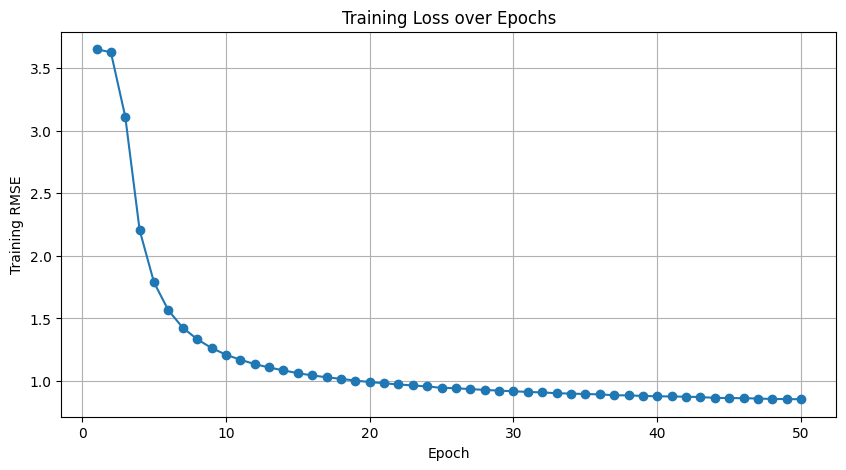

In [3]:
# Plot the training loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training RMSE')
plt.title('Training Loss over Epochs')
plt.grid()
plt.show()

Streaming output truncated to the last 5000 lines.
User 477.0, Movie 2082.0, Actual Rating: 3.5, Predicted Rating: 2.65
User 477.0, Movie 2105.0, Actual Rating: 3.5, Predicted Rating: 3.07
User 477.0, Movie 2109.0, Actual Rating: 3.5, Predicted Rating: 3.38
User 477.0, Movie 2114.0, Actual Rating: 3.5, Predicted Rating: 3.57
User 477.0, Movie 2116.0, Actual Rating: 4.0, Predicted Rating: 3.09
User 477.0, Movie 2123.0, Actual Rating: 2.5, Predicted Rating: 2.67
User 477.0, Movie 2138.0, Actual Rating: 4.0, Predicted Rating: 4.02
User 477.0, Movie 2174.0, Actual Rating: 3.0, Predicted Rating: 3.48
User 477.0, Movie 2208.0, Actual Rating: 4.0, Predicted Rating: 3.84
User 477.0, Movie 2294.0, Actual Rating: 4.0, Predicted Rating: 3.10
User 477.0, Movie 2297.0, Actual Rating: 4.0, Predicted Rating: 3.46
User 477.0, Movie 2395.0, Actual Rating: 4.5, Predicted Rating: 3.44
User 477.0, Movie 2407.0, Actual Rating: 3.5, Predicted Rating: 3.26
User 477.0, Movie 2416.0, Actual Rating: 3.5, Predic

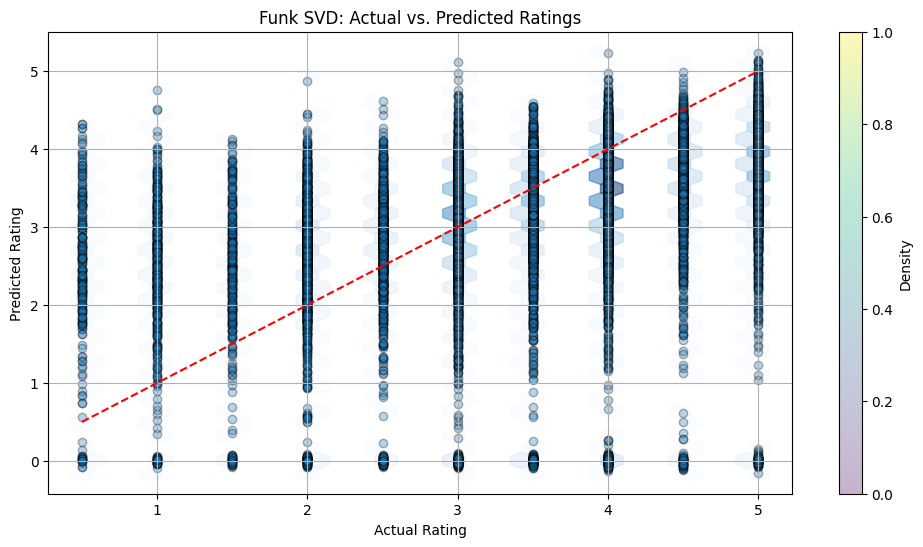

In [4]:
# Evaluate the Funk SVD model on the test set
test_loss = 0
test_true = []
test_pred = []

for _, row in test_data.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    rating = row['rating']

    if user_id in user_id_mapping and movie_id in movie_id_mapping:
        user_idx = user_id_mapping[user_id]
        movie_idx = movie_id_mapping[movie_id]
        prediction = np.dot(P[user_idx], Q[movie_idx])
        test_loss += (rating - prediction) ** 2
        test_true.append(rating)
        test_pred.append(prediction)
        print(f"User {user_id}, Movie {movie_id}, Actual Rating: {rating}, Predicted Rating: {prediction:.2f}")

test_rmse = np.sqrt(test_loss / len(test_data))
test_mae = mean_absolute_error(test_true, test_pred)

print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Hexbin and scatter plot of actual vs. predicted ratings for Funk SVD
plt.figure(figsize=(12, 6))
plt.hexbin(test_true, test_pred, gridsize=30, cmap='Blues', mincnt=1, alpha=0.5)
plt.scatter(test_true, test_pred, alpha=0.3, edgecolor='k')
plt.plot([min(test_true), max(test_true)], [min(test_true), max(test_true)], color='red', linestyle='--')
plt.colorbar(label='Density')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Funk SVD: Actual vs. Predicted Ratings')
plt.grid(True)
plt.show()

### DL

Epoch 1/10
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 2.3463 - root_mean_squared_error: 1.4374 - val_loss: 0.9345 - val_root_mean_squared_error: 0.9667
Epoch 2/10
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.7014 - root_mean_squared_error: 0.8375 - val_loss: 0.9245 - val_root_mean_squared_error: 0.9615
Epoch 3/10
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.6338 - root_mean_squared_error: 0.7961 - val_loss: 0.9057 - val_root_mean_squared_error: 0.9517
Epoch 4/10
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.5812 - root_mean_squared_error: 0.7623 - val_loss: 0.9267 - val_root_mean_squared_error: 0.9626
Epoch 5/10
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.4954 - root_mean_squared_error: 0.7038 - val_loss: 0.9749 - val_root_mean_squared_error: 0.9874
Epoch 6/10
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.4104 - root_mean_squared_error: 0.6405 - val_loss: 1.0554 - val_root_mean_squared_error: 1.0273
Epoch 7/10
1135/1135 ━━━━━━━━━━━━━━

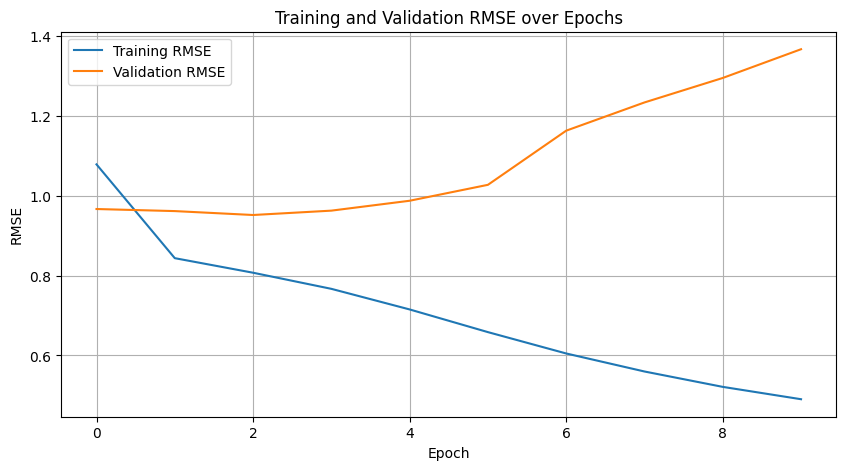

631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


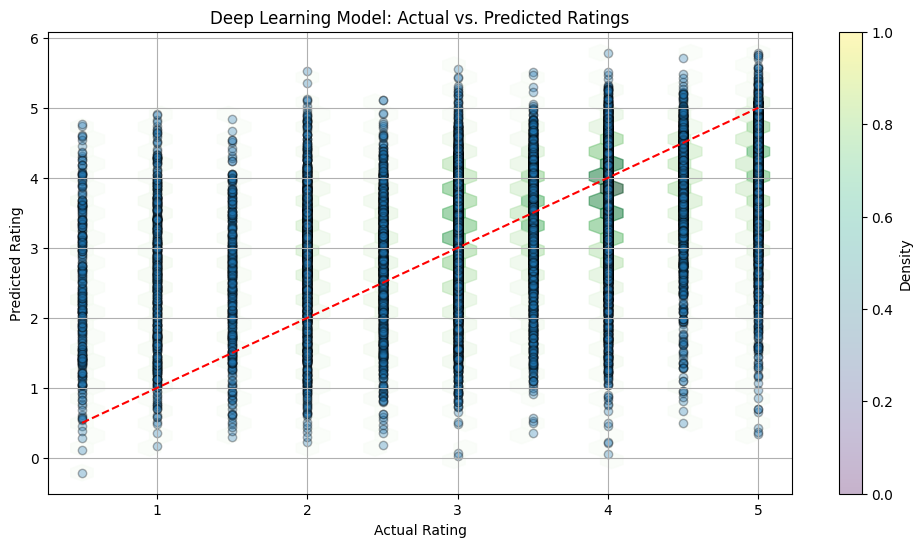


Comparison Summary:
Deep Learning Model Test RMSE: 1.0191


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error


user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
ratings_df['userId'] = user_encoder.fit_transform(ratings_df['userId'])
ratings_df['movieId'] = movie_encoder.fit_transform(ratings_df['movieId'])

n_users = ratings_df['userId'].nunique()
n_items = ratings_df['movieId'].nunique()

ratings_df['train_test_split'] = np.random.rand(len(ratings_df))
train_data = ratings_df[ratings_df['train_test_split'] <= 0.8]
test_data = ratings_df[ratings_df['train_test_split'] > 0.8]

train_user = train_data['userId'].values.astype(np.int32)
train_movie = train_data['movieId'].values.astype(np.int32)
train_rating = train_data['rating'].values

test_user = test_data['userId'].values.astype(np.int32)
test_movie = test_data['movieId'].values.astype(np.int32)
test_rating = test_data['rating'].values

embedding_dim = 50

input_user = tf.keras.layers.Input(shape=(1,), name='user_input')
input_movie = tf.keras.layers.Input(shape=(1,), name='movie_input')

user_embedding = tf.keras.layers.Embedding(input_dim=n_users, output_dim=embedding_dim, name='user_embedding')(input_user)
user_embedding = tf.keras.layers.Flatten()(user_embedding)

movie_embedding = tf.keras.layers.Embedding(input_dim=n_items, output_dim=embedding_dim, name='movie_embedding')(input_movie)
movie_embedding = tf.keras.layers.Flatten()(movie_embedding)

concat = tf.keras.layers.Concatenate()([user_embedding, movie_embedding])

dense_1 = tf.keras.layers.Dense(128, activation='relu')(concat)
dense_2 = tf.keras.layers.Dense(64, activation='relu')(dense_1)
dense_3 = tf.keras.layers.Dense(32, activation='relu')(dense_2)

output = tf.keras.layers.Dense(1)(dense_3)

model = tf.keras.models.Model(inputs=[input_user, input_movie], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Train Deep Learning Model
history = model.fit([train_user, train_movie], train_rating, validation_split=0.1, epochs=10, batch_size=64, verbose=1)

test_loss, test_rmse_dl = model.evaluate([test_user, test_movie], test_rating, verbose=0)
print(f"Deep Learning Model Test RMSE: {test_rmse_dl:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE over Epochs')
plt.legend()
plt.grid()
plt.show()

pred_dl = model.predict([test_user, test_movie]).flatten()

plt.figure(figsize=(12, 6))
plt.hexbin(test_rating, pred_dl, gridsize=30, cmap='Greens', mincnt=1, alpha=0.5)
plt.scatter(test_rating, pred_dl, alpha=0.3, edgecolor='k')
plt.plot([min(test_rating), max(test_rating)], [min(test_rating), max(test_rating)], color='red', linestyle='--')
plt.colorbar(label='Density')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Deep Learning Model: Actual vs. Predicted Ratings')
plt.grid(True)
plt.show()

print("\nComparison Summary:")
print(f"Deep Learning Model Test RMSE: {test_rmse_dl:.4f}")


### Improved

In [ ]:
# Map user and movie IDs to indices
user_id_mapping = {id: idx for idx, id in enumerate(ratings_df['userId'].unique())}
movie_id_mapping = {id: idx for idx, id in enumerate(ratings_df['movieId'].unique())}

# Initialize latent factor matrices
n_factors = 30  # Number of latent factors
P = np.random.normal(scale=1./n_factors, size=(n_users, n_factors))
Q = np.random.normal(scale=1./n_factors, size=(n_items, n_factors))
user_bias = np.zeros(n_users)
movie_bias = np.zeros(n_items)
global_bias = ratings_df['rating'].mean()

# Hyperparameters
learning_rate = 0.005
n_epochs = 50
reg = 0.2

# Hide some of the ratings for testing
ratings_df['train_test_split'] = np.random.rand(len(ratings_df))
train_data = ratings_df[ratings_df['train_test_split'] <= 0.8]
test_data = ratings_df[ratings_df['train_test_split'] > 0.8]

# Convert train_data to numpy array for faster access
train_data_np = train_data[['userId', 'movieId', 'rating']].values

# Training the Funk SVD model with bias terms using Adam optimizer
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
m_P, v_P = np.zeros_like(P), np.zeros_like(P)
m_Q, v_Q = np.zeros_like(Q), np.zeros_like(Q)
m_user_bias, v_user_bias = np.zeros_like(user_bias), np.zeros_like(user_bias)
m_movie_bias, v_movie_bias = np.zeros_like(movie_bias), np.zeros_like(movie_bias)
t = 0

for epoch in range(n_epochs):
    t += 1
    np.random.shuffle(train_data_np)
    for i in range(len(train_data_np)):
        user_id = train_data_np[i, 0]
        movie_id = train_data_np[i, 1]
        rating = train_data_np[i, 2]

        user_idx = user_id_mapping[user_id]
        movie_idx = movie_id_mapping[movie_id]

        # Predict the rating
        prediction = global_bias + user_bias[user_idx] + movie_bias[movie_idx] + np.dot(P[user_idx], Q[movie_idx])
        prediction = max(0, prediction)  # Ensure non-negative predictions
        error = rating - prediction

        # Adam optimizer updates
        # Update user bias
        m_user_bias[user_idx] = beta1 * m_user_bias[user_idx] + (1 - beta1) * error
        v_user_bias[user_idx] = beta2 * v_user_bias[user_idx] + (1 - beta2) * (error ** 2)
        m_user_bias_hat = m_user_bias[user_idx] / (1 - beta1 ** t)
        v_user_bias_hat = v_user_bias[user_idx] / (1 - beta2 ** t)
        user_bias[user_idx] += learning_rate * m_user_bias_hat / (np.sqrt(v_user_bias_hat) + epsilon)

        # Update movie bias
        m_movie_bias[movie_idx] = beta1 * m_movie_bias[movie_idx] + (1 - beta1) * error
        v_movie_bias[movie_idx] = beta2 * v_movie_bias[movie_idx] + (1 - beta2) * (error ** 2)
        m_movie_bias_hat = m_movie_bias[movie_idx] / (1 - beta1 ** t)
        v_movie_bias_hat = v_movie_bias[movie_idx] / (1 - beta2 ** t)
        movie_bias[movie_idx] += learning_rate * m_movie_bias_hat / (np.sqrt(v_movie_bias_hat) + epsilon)

        # Update latent factors P and Q
        grad_P = error * Q[movie_idx] - reg * P[user_idx]
        grad_Q = error * P[user_idx] - reg * Q[movie_idx]

        m_P[user_idx] = beta1 * m_P[user_idx] + (1 - beta1) * grad_P
        v_P[user_idx] = beta2 * v_P[user_idx] + (1 - beta2) * (grad_P ** 2)
        m_P_hat = m_P[user_idx] / (1 - beta1 ** t)
        v_P_hat = v_P[user_idx] / (1 - beta2 ** t)
        P[user_idx] += learning_rate * m_P_hat / (np.sqrt(v_P_hat) + epsilon)

        m_Q[movie_idx] = beta1 * m_Q[movie_idx] + (1 - beta1) * grad_Q
        v_Q[movie_idx] = beta2 * v_Q[movie_idx] + (1 - beta2) * (grad_Q ** 2)
        m_Q_hat = m_Q[movie_idx] / (1 - beta1 ** t)
        v_Q_hat = v_Q[movie_idx] / (1 - beta2 ** t)
        Q[movie_idx] += learning_rate * m_Q_hat / (np.sqrt(v_Q_hat) + epsilon)

        # Clip values to prevent overflow
        P[user_idx] = np.clip(P[user_idx], -5, 5)
        Q[movie_idx] = np.clip(Q[movie_idx], -5, 5)

    # Calculate training loss
    train_loss = 0
    for i in range(len(train_data_np)):
        user_id = train_data_np[i, 0]
        movie_id = train_data_np[i, 1]
        rating = train_data_np[i, 2]

        user_idx = user_id_mapping[user_id]
        movie_idx = movie_id_mapping[movie_id]

        prediction = global_bias + user_bias[user_idx] + movie_bias[movie_idx] + np.dot(P[user_idx], Q[movie_idx])
        train_loss += (rating - prediction) ** 2

    train_rmse = np.sqrt(train_loss / len(train_data_np))
    train_losses.append(train_rmse)
    print(f"Epoch {epoch+1}/{n_epochs}, Training RMSE: {train_rmse:.4f}")

In [ ]:

# Plot the training loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training RMSE')
plt.title('Training Loss over Epochs')
plt.grid()
plt.show()

In [ ]:
# Evaluate the Funk SVD model on the test set
test_loss = 0
test_true = []
test_pred = []

for _, row in test_data.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    rating = row['rating']

    if user_id in user_id_mapping and movie_id in movie_id_mapping:
        user_idx = user_id_mapping[user_id]
        movie_idx = movie_id_mapping[movie_id]
        prediction = global_bias + user_bias[user_idx] + movie_bias[movie_idx] + np.dot(P[user_idx], Q[movie_idx])
        test_loss += (rating - prediction) ** 2
        test_true.append(rating)
        test_pred.append(prediction)
        print(f"User {user_id}, Movie {movie_id}, Actual Rating: {rating}, Predicted Rating: {prediction:.2f}")

test_rmse = np.sqrt(test_loss / len(test_data))
test_mae = mean_absolute_error(test_true, test_pred)
test_r2 = r2_score(test_true, test_pred)

print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")

# Hexbin and scatter plot of actual vs. predicted ratings for Funk SVD
plt.figure(figsize=(12, 6))
plt.hexbin(test_true, test_pred, gridsize=30, cmap='Blues', mincnt=1, alpha=0.5)
plt.scatter(test_true, test_pred, alpha=0.3, edgecolor='k')
plt.plot([min(test_true), max(test_true)], [min(test_true), max(test_true)], color='red', linestyle='--')
plt.colorbar(label='Density')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Funk SVD: Actual vs. Predicted Ratings')
plt.grid(True)
plt.show()